[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/image_matching_disk.ipynb)

# Image matching example with DISK local features

First, we will install everything needed:


*  fresh version of [kornia](https://github.com/kornia/kornia) for [DISK](https://arxiv.org/abs/2006.13566)
*  fresh version of OpenCV for MAGSAC++ geometry estimation
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions and visualization

Docs: [`kornia.feature.DISK`](https://kornia.readthedocs.io/en/latest/feature.html#kornia.feature.DISK)


In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install kornia_moons --no-deps
!pip install opencv-python --upgrade

Now let's download an image pair


In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"
download_image(url_a)
download_image(url_b)

'kn_church-8.jpg'

First, imports.

In [ ]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *


def load_torch_image(fname, device=torch.device("cpu")):
    img = K.image_to_tensor(cv2.imread(fname), False).float() / 255.0
    img = K.color.bgr_to_rgb(img.to(device))
    return img


#device = torch.device("mps")  # it works also for Apple M1/M2
device = K.utils.get_cuda_device_if_available()
print(device)

mps


In [ ]:
# %%capture
fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

adalam_config = KF.adalam.get_adalam_default_config()
# adalam_config['orientation_difference_threshold'] = None
# adalam_config['scale_rate_threshold'] = None
adalam_config["force_seed_mnn"] = False
adalam_config["search_expansion"] = 16
adalam_config["ransac_iters"] = 256


img1 = load_torch_image(fname1, device)
img2 = load_torch_image(fname2, device)

num_features = 2048
disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

match_with_adalam = True

with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    if match_with_adalam:
        lafs1 = KF.laf_from_center_scale_ori(kps1[None], 96 * torch.ones(1, len(kps1), 1, 1, device=device))
        lafs2 = KF.laf_from_center_scale_ori(kps2[None], 96 * torch.ones(1, len(kps2), 1, 1, device=device))

        dists, idxs = KF.match_adalam(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2, config=adalam_config)
    else:
        dists, idxs = KF.match_smnn(descs1, descs2, 0.98)


print(f"{idxs.shape[0]} tentative matches with DISK AdaLAM")

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/kornia/feature/disk/detector.py:45: UserWarning: The operator 'aten::kthvalue.values' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:12.)
  minus_threshold, _indices = torch.kthvalue(-detection_logp, n_)


218 tentative matches with DISK AdaLAM


In [ ]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with DISK")

98 inliers with DISK


Let's draw the inliers in green and tentative correspondences in yellow

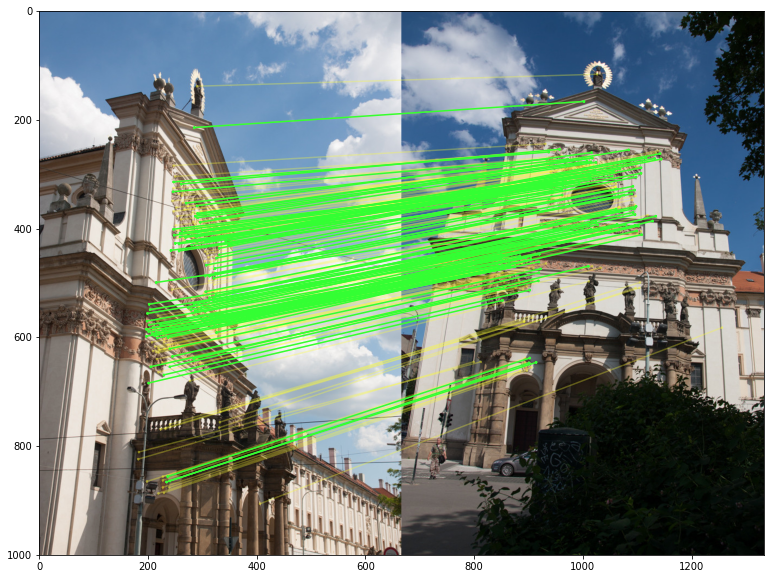

In [ ]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)